## Logistic Regression on broadband availability v2
(improving on https://github.com/angelhe903/broadband-research/blob/main/ruca_demographic_broadband_analysis_fcc%26non_logistic_reg2.ipynb)


* All residential blocks in contiguous U.S. with complete data are considered, for year 2018
* newly included index of deep advantage (https://docs.google.com/spreadsheets/d/1i_Voy-hmA66pSQ2fx44Q5g7AIrjtV2VbG3E-aar2jk8/edit#gid=1674430546) and social capital index (https://www.jec.senate.gov/public/index.cfm/republicans/2018/4/the-geography-of-social-capital-in-america) data 
* Data file uploaded to google cloud, in BigQuery's combined data bucket as 'fcc477_2018_grouped_ruca_demographic_byblock_with_social_variables', in Cloud Storage's broadband-data bucket as 'fcc477_2018_grouped_ruca_demographic_byblock_with_social_variables_with_DC'
* fixed negative pseudo R squared by adding an intercept column, because intercept is not included by default (see https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html)

### Outline:
1. data import & cleaning
2. logistic regression on all numerical features unregularized & regularized
3. logistic regression with only a few variables for comparison  
    * percent population living in urban or rural area is better indicator of broadband availability (25/3 and 100/10) than primary ruca code
    * Summary of goodness of fit of all models at the very end

### 1. data import & cleaning

In [47]:
import numpy as np
import pandas as pd

In [3]:
df=pd.read_csv('fcc477_2018_grouped_ruca_demographic_byblock_with_social_variables_with_DC.csv') #> 8250217 rows?
df.info()
df.head()

/Users/yapinghe/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (57,58,77) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8254631 entries, 0 to 8254630
Columns: 101 entries, BlockCode to Violent Crimes p 100,000
dtypes: float64(69), int64(18), object(14)
memory usage: 6.2+ GB


,BlockCode,NumberOfUniqueProviderNames,NumberOfUniqueHocoNums,MeanMaxAdDown,MeanMaxAdUp,SdMaxAdDown,SdMaxAdUp,NumberOfUniqueTechCodes,GIDBG,State-County-Tract FIPS Code (lookup by address at http://www.ffiec.gov/Geocode/),...,% births to unmarried women,% women currently married,% children with single parent,"Non-religious non-profit organizations p 1,000","Religious congregations p 1,000",Informal Civic Engagement Subindex,"Presidential election voting rate, 2012 & 2016",Mail-back census response rate,Confidence in Institutions Subindex,"Violent Crimes p 100,000"
0,10010201001000,3,3,592.800000,27.256,530.777920,25.056957,5,10010201001,1001020100,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
1,10010201001001,1,1,940.000000,35.000,NaN,NaN,1,10010201001,1001020100,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
2,10010201001002,2,2,317.333333,12.008,539.245151,19.911656,3,10010201001,1001020100,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
3,10010201001003,2,2,319.333333,12.008,537.521472,19.911656,3,10010201001,1001020100,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
4,10010201001004,1,1,940.000000,35.000,NaN,NaN,1,10010201001,1001020100,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7


In [4]:
print(list(df.columns))

['BlockCode', 'NumberOfUniqueProviderNames', 'NumberOfUniqueHocoNums', 'MeanMaxAdDown', 'MeanMaxAdUp', 'SdMaxAdDown', 'SdMaxAdUp', 'NumberOfUniqueTechCodes', 'GIDBG', 'State-County-Tract FIPS Code (lookup by address at http://www.ffiec.gov/Geocode/)', 'Tot_Population_ACS_14_18', 'pct_URBANIZED_AREA_POP_CEN_2010', 'pct_URBAN_CLUSTER_POP_CEN_2010', 'pct_RURAL_POP_CEN_2010', 'avg_Tot_Prns_in_HHD_ACS_14_18', 'pct_Vacant_Units_ACS_14_18', 'pct_Hispanic_ACS_14_18', 'pct_NH_White_alone_ACS_14_18', 'pct_NH_Blk_alone_ACS_14_18', 'pct_NH_AIAN_alone_ACS_14_18', 'pct_NH_Asian_alone_ACS_14_18', 'pct_NH_NHOPI_alone_ACS_14_18', 'pct_NH_SOR_alone_ACS_14_18', 'pct_Othr_Lang_ACS_14_18', 'pct_ENG_VW_ACS_14_18', 'pct_Not_HS_Grad_ACS_14_18', 'pct_College_ACS_14_18', 'avg_Agg_HH_INC_ACS_14_18', 'pct_Prs_Blw_Pov_Lev_ACS_14_18', 'pct_PUB_ASST_INC_ACS_14_18', 'pct_Diff_HU_1yr_Ago_ACS_14_18', 'pct_Recent_Built_HU_ACS_14_18', 'avg_Agg_House_Value_ACS_14_18', 'State-County FIPS Code', 'Select State', 'Select Coun

**Notes on dataset:**
This is the raw dataset from joining the FCC aggregate data, demographic, RUCA, index of deep advantage, and social capital index data, so it contains some redundant columns. They will be taken out before logistic regression.  
1. Columns 'BlockCode' through 'NumberOfUniqueHocoNums', as well as columns 'NumFCCEntriesWith25/3Speed', 'NumFCCEntriesWith100/10Speed', 'AnyProviderWith25/3' (binary), 'AnyProviderWith100/10' (binary) are block-level aggregate data from 2018 FCC form 477  
2. Columns 'GIDBG' through 'avg_Agg_House_Value_ACS_14_18' are block group level demographic data from Census
3. Columns 'State-County FIPS Code' through 'Population Density (per square mile), 2010' are tract level RUCA data from USDA
4. Columns 'rank' through 'teenbirthrate' are county level index of deep disadvantage data (see top of notebook for source)
5. Columns 'County-Level Index' through 'Violent Crimes p 100,000' are social capital index data (see top of notebook for source)


Filter out non-contiguous U.S. areas:

In [5]:
df_conus=df[(df['Select State']!='AK')& (df['Select State']!='HI')]
np.unique(df_conus['Select State']),len(np.unique(df_conus['Select State']))

(array(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA',
        'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
        'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY',
        'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
        'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object),
 49)

Select all the numerical columns:

In [6]:
# construct numerical dataset, with all numerical columns
# df_conus_num contains all the nulls
df_conus_num=df_conus[['NumberOfUniqueProviderNames','NumberOfUniqueHocoNums',\
                       'NumberOfUniqueTechCodes','NumFCCEntriesWith25/3Speed','NumFCCEntriesWith100/10Speed',\
                       'AnyProviderWith25/3','AnyProviderWith100/10',
                       'MeanMaxAdDown','MeanMaxAdUp','Tot_Population_ACS_14_18', 'pct_URBANIZED_AREA_POP_CEN_2010',
       'pct_URBAN_CLUSTER_POP_CEN_2010', 'pct_RURAL_POP_CEN_2010',
       'avg_Tot_Prns_in_HHD_ACS_14_18', 'pct_Vacant_Units_ACS_14_18',
       'pct_Hispanic_ACS_14_18', 'pct_NH_White_alone_ACS_14_18',
       'pct_NH_Blk_alone_ACS_14_18', 'pct_NH_AIAN_alone_ACS_14_18',
       'pct_NH_Asian_alone_ACS_14_18', 'pct_NH_NHOPI_alone_ACS_14_18',
       'pct_NH_SOR_alone_ACS_14_18', 'pct_Othr_Lang_ACS_14_18',
       'pct_ENG_VW_ACS_14_18', 'pct_Not_HS_Grad_ACS_14_18',
       'pct_College_ACS_14_18', 'avg_Agg_HH_INC_ACS_14_18',
       'pct_Prs_Blw_Pov_Lev_ACS_14_18', 'pct_PUB_ASST_INC_ACS_14_18',
       'pct_Diff_HU_1yr_Ago_ACS_14_18', 'pct_Recent_Built_HU_ACS_14_18',
       'avg_Agg_House_Value_ACS_14_18','Primary RUCA Code 2010','Secondary RUCA Code, 2010 (see errata)', 'Tract Population, 2010',
       'Land Area (square miles), 2010',
       'Population Density (per square mile), 2010','rank','index','mobility_raw','pct_belowpov_raw',\
                      'pct_deeppov_raw','life_exp_raw','lbw_raw','urban','rural','reservation','city',\
                      'tot_pop','pct_lths','lfpr','pct_bachmore','teenbirthrate','County-Level Index', \
                       'Requiring all 4 Subindices', 'Excluding Collective Efficacy', 'Family Unity', \
                       'Community Health', 'Institutional Health', 'Collective Efficacy', \
                       '% births to unmarried women', '% women currently married', '% children with single parent', \
                       'Non-religious non-profit organizations p 1,000', 'Religious congregations p 1,000', \
                       'Informal Civic Engagement Subindex', 'Presidential election voting rate, 2012 & 2016', \
                       'Mail-back census response rate', 'Confidence in Institutions Subindex', 'Violent Crimes p 100,000']]
# df_conus_num['teenbirthrate']=df_conus_num['teenbirthrate'].astype(float)  #doesn't work because has ''
df_conus_num.info() #teenbirthrate is object type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8232809 entries, 0 to 8254630
Data columns (total 70 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   NumberOfUniqueProviderNames                     int64  
 1   NumberOfUniqueHocoNums                          int64  
 2   NumberOfUniqueTechCodes                         int64  
 3   NumFCCEntriesWith25/3Speed                      int64  
 4   NumFCCEntriesWith100/10Speed                    int64  
 5   AnyProviderWith25/3                             int64  
 6   AnyProviderWith100/10                           int64  
 7   MeanMaxAdDown                                   float64
 8   MeanMaxAdUp                                     float64
 9   Tot_Population_ACS_14_18                        float64
 10  pct_URBANIZED_AREA_POP_CEN_2010                 float64
 11  pct_URBAN_CLUSTER_POP_CEN_2010                  float64
 12  pct_RURAL_POP_CEN_2010      

Drop teenbirthrate for now because its format is weird and it is captured in the index of deep disadvantage data, column named 'index':

In [7]:
df_conus_num.drop(columns=['teenbirthrate'])
df_conus_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8232809 entries, 0 to 8254630
Data columns (total 70 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   NumberOfUniqueProviderNames                     int64  
 1   NumberOfUniqueHocoNums                          int64  
 2   NumberOfUniqueTechCodes                         int64  
 3   NumFCCEntriesWith25/3Speed                      int64  
 4   NumFCCEntriesWith100/10Speed                    int64  
 5   AnyProviderWith25/3                             int64  
 6   AnyProviderWith100/10                           int64  
 7   MeanMaxAdDown                                   float64
 8   MeanMaxAdUp                                     float64
 9   Tot_Population_ACS_14_18                        float64
 10  pct_URBANIZED_AREA_POP_CEN_2010                 float64
 11  pct_URBAN_CLUSTER_POP_CEN_2010                  float64
 12  pct_RURAL_POP_CEN_2010      

drop rows containing na and we still have 96.6% of total rows left:

In [8]:
df_num_2=df_conus_num.dropna() # a fair number left
df_num_2

,NumberOfUniqueProviderNames,NumberOfUniqueHocoNums,NumberOfUniqueTechCodes,NumFCCEntriesWith25/3Speed,NumFCCEntriesWith100/10Speed,AnyProviderWith25/3,AnyProviderWith100/10,MeanMaxAdDown,MeanMaxAdUp,Tot_Population_ACS_14_18,...,% births to unmarried women,% women currently married,% children with single parent,"Non-religious non-profit organizations p 1,000","Religious congregations p 1,000",Informal Civic Engagement Subindex,"Presidential election voting rate, 2012 & 2016",Mail-back census response rate,Confidence in Institutions Subindex,"Violent Crimes p 100,000"
0,3,3,5,3,3,1,1,592.800000,27.256000,636.0,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
1,1,1,1,1,1,1,1,940.000000,35.000000,636.0,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
2,2,2,3,1,1,1,1,317.333333,12.008000,636.0,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
3,2,2,3,1,1,1,1,319.333333,12.008000,636.0,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
4,1,1,1,1,1,1,1,940.000000,35.000000,636.0,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8254626,1,1,1,1,0,1,0,50.000000,5.000000,1375.0,...,14.4,82.5,23.1,8.0,2.5,0.414574,62.4,65.0,0.423832,143.4
8254627,1,1,1,0,0,0,0,10.000000,1.000000,1375.0,...,14.4,82.5,23.1,8.0,2.5,0.414574,62.4,65.0,0.423832,143.4
8254628,3,3,2,3,0,1,0,35.000000,8.333333,1375.0,...,14.4,82.5,23.1,8.0,2.5,0.414574,62.4,65.0,0.423832,143.4
8254629,1,1,1,0,0,0,0,10.000000,1.000000,1375.0,...,14.4,82.5,23.1,8.0,2.5,0.414574,62.4,65.0,0.423832,143.4


Quick stats on dependent binary variables 'AnyProviderWith25/3' and 'AnyProviderWith100/10':

In [45]:
np.unique(df_num_2['AnyProviderWith25/3'],return_counts=True),1536943/6419252
print("Number of blocks with no provider with speed above 25/3:",np.unique(df_num_2['AnyProviderWith25/3'],return_counts=True)[1][0])
print("Number of blocks with at least 1 provider with speed above 25/3:",np.unique(df_num_2['AnyProviderWith25/3'],return_counts=True)[1][1])

Number of blocks with no provider with speed above 25/3: 1536943
Number of blocks with at least 1 provider with speed above 25/3: 6419252


In [46]:
np.unique(df_num_2['AnyProviderWith100/10'],return_counts=True),2505975/5450220
print("Number of blocks with no provider with speed above 100/10:",np.unique(df_num_2['AnyProviderWith100/10'],return_counts=True)[1][0])
print("Number of blocks with at least 1 provider with speed above 100/10:",np.unique(df_num_2['AnyProviderWith100/10'],return_counts=True)[1][1])

Number of blocks with no provider with speed above 100/10: 2505975
Number of blocks with at least 1 provider with speed above 100/10: 5450220


A list and dataframe containing all potential independent variables:

In [9]:
all_x_li=['Tot_Population_ACS_14_18', 'pct_URBANIZED_AREA_POP_CEN_2010',
       'pct_URBAN_CLUSTER_POP_CEN_2010', 'pct_RURAL_POP_CEN_2010',
       'avg_Tot_Prns_in_HHD_ACS_14_18', 'pct_Vacant_Units_ACS_14_18',
       'pct_Hispanic_ACS_14_18', 'pct_NH_White_alone_ACS_14_18',
       'pct_NH_Blk_alone_ACS_14_18', 'pct_NH_AIAN_alone_ACS_14_18',
       'pct_NH_Asian_alone_ACS_14_18', 'pct_NH_NHOPI_alone_ACS_14_18',
       'pct_NH_SOR_alone_ACS_14_18', 'pct_Othr_Lang_ACS_14_18',
       'pct_ENG_VW_ACS_14_18', 'pct_Not_HS_Grad_ACS_14_18',
       'pct_College_ACS_14_18', 'avg_Agg_HH_INC_ACS_14_18',
       'pct_Prs_Blw_Pov_Lev_ACS_14_18', 'pct_PUB_ASST_INC_ACS_14_18',
       'pct_Diff_HU_1yr_Ago_ACS_14_18', 'pct_Recent_Built_HU_ACS_14_18',
       'avg_Agg_House_Value_ACS_14_18','Primary RUCA Code 2010','Secondary RUCA Code, 2010 (see errata)', 'Tract Population, 2010',
       'Land Area (square miles), 2010',
       'Population Density (per square mile), 2010','rank','index','mobility_raw','pct_belowpov_raw',\
                      'pct_deeppov_raw','life_exp_raw','lbw_raw','urban','rural','reservation','city',\
                      'tot_pop','pct_lths','lfpr','pct_bachmore','County-Level Index', \
                       'Requiring all 4 Subindices', 'Excluding Collective Efficacy', 'Family Unity', \
                       'Community Health', 'Institutional Health', 'Collective Efficacy', \
                       '% births to unmarried women', '% women currently married', '% children with single parent', \
                       'Non-religious non-profit organizations p 1,000', 'Religious congregations p 1,000', \
                       'Informal Civic Engagement Subindex', 'Presidential election voting rate, 2012 & 2016', \
                       'Mail-back census response rate', 'Confidence in Institutions Subindex', 'Violent Crimes p 100,000']
x1=df_num_2[all_x_li]
x1

,Tot_Population_ACS_14_18,pct_URBANIZED_AREA_POP_CEN_2010,pct_URBAN_CLUSTER_POP_CEN_2010,pct_RURAL_POP_CEN_2010,avg_Tot_Prns_in_HHD_ACS_14_18,pct_Vacant_Units_ACS_14_18,pct_Hispanic_ACS_14_18,pct_NH_White_alone_ACS_14_18,pct_NH_Blk_alone_ACS_14_18,pct_NH_AIAN_alone_ACS_14_18,...,% births to unmarried women,% women currently married,% children with single parent,"Non-religious non-profit organizations p 1,000","Religious congregations p 1,000",Informal Civic Engagement Subindex,"Presidential election voting rate, 2012 & 2016",Mail-back census response rate,Confidence in Institutions Subindex,"Violent Crimes p 100,000"
0,636.0,75.07,0.00,24.93,2.16,0.00,2.20,83.65,6.92,0.0,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
1,636.0,75.07,0.00,24.93,2.16,0.00,2.20,83.65,6.92,0.0,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
2,636.0,75.07,0.00,24.93,2.16,0.00,2.20,83.65,6.92,0.0,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
3,636.0,75.07,0.00,24.93,2.16,0.00,2.20,83.65,6.92,0.0,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
4,636.0,75.07,0.00,24.93,2.16,0.00,2.20,83.65,6.92,0.0,...,29.6,65.2,22.4,2.2,1.9,-1.032341,60.5,78.0,0.208587,265.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8254626,1375.0,0.00,72.55,27.45,2.50,5.16,0.95,83.42,0.00,0.0,...,14.4,82.5,23.1,8.0,2.5,0.414574,62.4,65.0,0.423832,143.4
8254627,1375.0,0.00,72.55,27.45,2.50,5.16,0.95,83.42,0.00,0.0,...,14.4,82.5,23.1,8.0,2.5,0.414574,62.4,65.0,0.423832,143.4
8254628,1375.0,0.00,72.55,27.45,2.50,5.16,0.95,83.42,0.00,0.0,...,14.4,82.5,23.1,8.0,2.5,0.414574,62.4,65.0,0.423832,143.4
8254629,1375.0,0.00,72.55,27.45,2.50,5.16,0.95,83.42,0.00,0.0,...,14.4,82.5,23.1,8.0,2.5,0.414574,62.4,65.0,0.423832,143.4


Remove some of the more detailed social variables (included in the derivation of aggregate measures 'index' and 'County-Level Index') because otherwise logistic regression would fail due to singular value matrices:

In [10]:
x1=x1[['Tot_Population_ACS_14_18', 'pct_URBANIZED_AREA_POP_CEN_2010',
       'pct_URBAN_CLUSTER_POP_CEN_2010', 'pct_RURAL_POP_CEN_2010',
       'avg_Tot_Prns_in_HHD_ACS_14_18', 'pct_Vacant_Units_ACS_14_18',
       'pct_Hispanic_ACS_14_18', 'pct_NH_White_alone_ACS_14_18',
       'pct_NH_Blk_alone_ACS_14_18', 'pct_NH_AIAN_alone_ACS_14_18',
       'pct_NH_Asian_alone_ACS_14_18', 'pct_NH_NHOPI_alone_ACS_14_18',
       'pct_NH_SOR_alone_ACS_14_18', 'pct_Othr_Lang_ACS_14_18',
       'pct_ENG_VW_ACS_14_18', 'pct_Not_HS_Grad_ACS_14_18',
       'pct_College_ACS_14_18', 'avg_Agg_HH_INC_ACS_14_18',
       'pct_Prs_Blw_Pov_Lev_ACS_14_18', 'pct_PUB_ASST_INC_ACS_14_18',
       'pct_Diff_HU_1yr_Ago_ACS_14_18', 'pct_Recent_Built_HU_ACS_14_18',
       'avg_Agg_House_Value_ACS_14_18','Primary RUCA Code 2010','Secondary RUCA Code, 2010 (see errata)', #'Tract Population, 2010',
       'Land Area (square miles), 2010',
       'Population Density (per square mile), 2010','index','mobility_raw','pct_belowpov_raw',\
                      'pct_deeppov_raw','life_exp_raw','lbw_raw','reservation',\
                      'tot_pop','lfpr','County-Level Index', \
                       'Excluding Collective Efficacy', 'Family Unity', \
                       'Community Health', 'Institutional Health', 'Collective Efficacy']] #, \
#                        '% births to unmarried women', '% women currently married', '% children with single parent', \
#                        'Non-religious non-profit organizations p 1,000', 'Religious congregations p 1,000', \
#                        'Informal Civic Engagement Subindex', 'Presidential election voting rate, 2012 & 2016', \
#                        'Mail-back census response rate', 'Confidence in Institutions Subindex', 'Violent Crimes p 100,000']]
x1.head()

,Tot_Population_ACS_14_18,pct_URBANIZED_AREA_POP_CEN_2010,pct_URBAN_CLUSTER_POP_CEN_2010,pct_RURAL_POP_CEN_2010,avg_Tot_Prns_in_HHD_ACS_14_18,pct_Vacant_Units_ACS_14_18,pct_Hispanic_ACS_14_18,pct_NH_White_alone_ACS_14_18,pct_NH_Blk_alone_ACS_14_18,pct_NH_AIAN_alone_ACS_14_18,...,lbw_raw,reservation,tot_pop,lfpr,County-Level Index,Excluding Collective Efficacy,Family Unity,Community Health,Institutional Health,Collective Efficacy
0,636.0,75.07,0.0,24.93,2.16,0.0,2.2,83.65,6.92,0.0,...,8.475719,0.0,55036,60.34,0.021923,0.039722,0.559294,-1.018466,0.453637,-0.104853
1,636.0,75.07,0.0,24.93,2.16,0.0,2.2,83.65,6.92,0.0,...,8.475719,0.0,55036,60.34,0.021923,0.039722,0.559294,-1.018466,0.453637,-0.104853
2,636.0,75.07,0.0,24.93,2.16,0.0,2.2,83.65,6.92,0.0,...,8.475719,0.0,55036,60.34,0.021923,0.039722,0.559294,-1.018466,0.453637,-0.104853
3,636.0,75.07,0.0,24.93,2.16,0.0,2.2,83.65,6.92,0.0,...,8.475719,0.0,55036,60.34,0.021923,0.039722,0.559294,-1.018466,0.453637,-0.104853
4,636.0,75.07,0.0,24.93,2.16,0.0,2.2,83.65,6.92,0.0,...,8.475719,0.0,55036,60.34,0.021923,0.039722,0.559294,-1.018466,0.453637,-0.104853


reset index so they match:

In [11]:
y1=df_num_2['AnyProviderWith25/3']
x1.reset_index(inplace=True,drop=True)
y1.reset_index(inplace=True,drop=True)
# x1.tail(1),y1

In [40]:
y2=df_num_2['AnyProviderWith100/10']
y2.reset_index(inplace=True,drop=True)

Standardize feature variables so they have mean = 0 and std = 1:

In [12]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
x1 = scaler.fit_transform(x1)
x1 = pd.DataFrame(x1,columns=['Tot_Population_ACS_14_18', 'pct_URBANIZED_AREA_POP_CEN_2010',
       'pct_URBAN_CLUSTER_POP_CEN_2010', 'pct_RURAL_POP_CEN_2010',
       'avg_Tot_Prns_in_HHD_ACS_14_18', 'pct_Vacant_Units_ACS_14_18',
       'pct_Hispanic_ACS_14_18', 'pct_NH_White_alone_ACS_14_18',
       'pct_NH_Blk_alone_ACS_14_18', 'pct_NH_AIAN_alone_ACS_14_18',
       'pct_NH_Asian_alone_ACS_14_18', 'pct_NH_NHOPI_alone_ACS_14_18',
       'pct_NH_SOR_alone_ACS_14_18', 'pct_Othr_Lang_ACS_14_18',
       'pct_ENG_VW_ACS_14_18', 'pct_Not_HS_Grad_ACS_14_18',
       'pct_College_ACS_14_18', 'avg_Agg_HH_INC_ACS_14_18',
       'pct_Prs_Blw_Pov_Lev_ACS_14_18', 'pct_PUB_ASST_INC_ACS_14_18',
       'pct_Diff_HU_1yr_Ago_ACS_14_18', 'pct_Recent_Built_HU_ACS_14_18',
       'avg_Agg_House_Value_ACS_14_18','Primary RUCA Code 2010','Secondary RUCA Code, 2010 (see errata)', #'Tract Population, 2010',
       'Land Area (square miles), 2010',
       'Population Density (per square mile), 2010','index','mobility_raw','pct_belowpov_raw',\
                      'pct_deeppov_raw','life_exp_raw','lbw_raw','reservation',\
                      'tot_pop','lfpr','County-Level Index', \
                       'Excluding Collective Efficacy', 'Family Unity', \
                       'Community Health', 'Institutional Health', 'Collective Efficacy'])

Add intercept column because statsmodels does not do it by default:  
(this simple step makes all pseudo R squared positive)

In [13]:
x1['intercept']=np.repeat(1,len(x1))

### 2. logistic regression on all numerical features unregularized & regularized


**First LR on all features unregularized (no penalty on coefficients):**

In [14]:
model = sm.Logit(y1, x1)
result = model.fit()
result.summary()

         Current function value: 0.392820
         Iterations: 35


/Users/yapinghe/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     AnyProviderWith25/3   No. Observations:              7956195
Model:                           Logit   Df Residuals:                  7956152
Method:                            MLE   Df Model:                           42
Date:                 Sun, 23 May 2021   Pseudo R-squ.:                  0.1996
Time:                         11:55:33   Log-Likelihood:            -3.1254e+06
converged:                       False   LL-Null:                   -3.9049e+06
Covariance Type:             nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Tot_Population_ACS_14_18                       0.0790      0.002     43.869      0.000       0.076       0.083
pct_URBANIZED_AREA_POP_CEN_2010             1144.0036    155.018      7.380      0.000     840.174    1447.834
pct_URBAN_CLUSTER_POP_CEN_2010               740.6283    100.368      7.379      0.000     543.912     937.345
pct_RURAL_POP_CEN_2010                      1106.9204    150.097      7.375      0.000     812.736    1401.105
avg_Tot_Prns_in_HHD_ACS_14_18                 -0.0177      0.001    -11.835      0.000      -0.021      -0.015
pct_Vacant_Units_ACS_14_18                    -0.0416      0.001    -37.807      0.000      -0.044      -0.039
pct_Hispanic_ACS_14_18                         0.2010      0.008     25.586      0.000       0.186       0.216
pct_NH_White_alone_ACS_14_18                   0.0939      0.010      8.987      0.000       0.073       0.114
pct_NH_Blk_alone_ACS_14_18                    -0.0145      0.007     -2.154      0.031      -0.028      -0.001
pct_NH_AIAN_alone_ACS_14_18                   -0.0808      0.004    -22.350      0.000      -0.088      -0.074
pct_NH_Asian_alone_ACS_14_18                   0.0990      0.004     27.461      0.000       0.092       0.106
pct_NH_NHOPI_alone_ACS_14_18                   0.0131      0.001      9.389      0.000       0.010       0.016
pct_NH_SOR_alone_ACS_14_18                     0.0337      0.002     21.512      0.000       0.031       0.037
pct_Othr_Lang_ACS_14_18                       -0.2337      0.003    -71.240      0.000      -0.240      -0.227
pct_ENG_VW_ACS_14_18                           0.0329      0.002     16.708      0.000       0.029       0.037
pct_Not_HS_Grad_ACS_14_18                     -0.0028      0.002     -1.623      0.105      -0.006       0.001
pct_College_ACS_14_18                          0.0446      0.002     19.698      0.000       0.040       0.049
avg_Agg_HH_INC_ACS_14_18                       0.1069      0.003     38.586      0.000       0.102       0.112
pct_Prs_Blw_Pov_Lev_ACS_14_18                  0.0323      0.002     21.175      0.000       0.029       0.035
pct_PUB_ASST_INC_ACS_14_18                     0.0525      0.001     43.142      0.000       0.050       0.055
pct_Diff_HU_1yr_Ago_ACS_14_18                 -0.0193      0.001    -15.848      0.000      -0.022      -0.017
pct_Recent_Built_HU_ACS_14_18                 -0.0406      0.001    -35.023      0.000      -0.043      -0.038
avg_Agg_House_Value_ACS_14_18                  0.0764      0.002     31.687      0.000       0.072       0.081
Primary RUCA Code 2010                        -1.8437      0.087    -21.097      0.000      -2.015      -1.672
Secondary RUCA Code, 2010 (see errata)         1.8306      0.087     20.965      0.000       1.659       2.002
Land Area (square miles), 2010                -0.1712      0.001   -157.778      0.000      -0.173      -0.169
Population De

In [15]:
import os
os.system('say "your program has finished"')

0

This regression has a high pseudo R squared of 0.1996 (statsmodels uses McFadden's R squared and 0.2-0.4 represents excellent fit), however it uses too many variables and there are some large standard errors and p-values. We should remove some of the multicollinear/redundant features.



An alternative pseudo R squared, Efron's R squared, that emphasizes the squared correlation between actual and predicted values (for details see https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/):

In [18]:
# compute efron's r squared
yhat1=result.predict(x1)
numerator1=np.sum(np.power(y1-yhat1,2))
denominator1=np.sum(np.power(y1-np.mean(y1),2))
R2_effron_1=1-numerator1/denominator1
R2_effron_1 #slightly less than mcfadden's

0.19589136385528172

It is close to McFadden's.

**Next LR on all features with lasso penalty, with arbitrary alpha = 0.2:**

In [14]:
# regularized on all features
model = sm.Logit(y1, x1) # all features
result = model.fit_regularized(method='l1_cvxopt_cp',alpha=0.2,trim_mode='size') # try random value
result.summary()

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  6.9315e-01  9e+01  1e+00  1e+00
 1:  5.3396e-01 -8.9946e+00  1e+01  1e-01  1e-01
 2:  2.9826e-01 -5.6008e-01  1e+00  2e-02  1e-02
 3:  3.6639e-01  2.3305e-01  2e-01  5e-03  3e-03
 4:  3.8513e-01  3.6397e-01  3e-02  1e-03  1e-03
 5:  3.9156e-01  3.9109e-01  2e-03  2e-04  3e-04
 6:  3.9231e-01  3.9219e-01  8e-04  7e-05  1e-04
 7:  3.9261e-01  3.9254e-01  4e-04  3e-05  5e-05
 8:  3.9281e-01  3.9281e-01  9e-05  8e-06  1e-05
 9:  3.9288e-01  3.9288e-01  7e-06  5e-07  9e-07
10:  3.9289e-01  3.9287e-01  1e-06  2e-06  8e-09
11:  3.9287e-01  3.9282e-01  9e-08  5e-06  4e-10
12:  3.9284e-01  3.9282e-01  3e-08  2e-06  1e-10
13:  3.9283e-01  3.9282e-01  1e-08  5e-07  4e-11
14:  3.9282e-01  3.9282e-01  3e-09  1e-07  9e-12
15:  3.9282e-01  3.9282e-01  7e-10  4e-08  2e-12
Optimal solution found.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     AnyProviderWith25/3   No. Observations:              7956195
Model:                           Logit   Df Residuals:                  7956152
Method:                            MLE   Df Model:                           42
Date:                 Fri, 21 May 2021   Pseudo R-squ.:                  0.1996
Time:                         19:00:49   Log-Likelihood:            -3.1253e+06
converged:                        True   LL-Null:                   -3.9049e+06
Covariance Type:             nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Tot_Population_ACS_14_18                       0.0795      0.002     44.163      0.000       0.076       0.083
pct_URBANIZED_AREA_POP_CEN_2010                0.0972    150.111      0.001      0.999    -294.115     294.310
pct_URBAN_CLUSTER_POP_CEN_2010                -0.0011     97.190  -1.11e-05      1.000    -190.491     190.489
pct_RURAL_POP_CEN_2010                        -0.6702    145.345     -0.005      0.996    -285.542     284.202
avg_Tot_Prns_in_HHD_ACS_14_18                 -0.0178      0.001    -11.883      0.000      -0.021      -0.015
pct_Vacant_Units_ACS_14_18                    -0.0415      0.001    -37.787      0.000      -0.044      -0.039
pct_Hispanic_ACS_14_18                         0.2001      0.008     25.470      0.000       0.185       0.215
pct_NH_White_alone_ACS_14_18                   0.0925      0.010      8.854      0.000       0.072       0.113
pct_NH_Blk_alone_ACS_14_18                    -0.0154      0.007     -2.282      0.022      -0.029      -0.002
pct_NH_AIAN_alone_ACS_14_18                   -0.0813      0.004    -22.467      0.000      -0.088      -0.074
pct_NH_Asian_alone_ACS_14_18                   0.0985      0.004     27.335      0.000       0.091       0.106
pct_NH_NHOPI_alone_ACS_14_18                   0.0129      0.001      9.205      0.000       0.010       0.016
pct_NH_SOR_alone_ACS_14_18                     0.0337      0.002     21.472      0.000       0.031       0.037
pct_Othr_Lang_ACS_14_18                       -0.2336      0.003    -71.217      0.000      -0.240      -0.227
pct_ENG_VW_ACS_14_18                           0.0328      0.002     16.672      0.000       0.029       0.037
pct_Not_HS_Grad_ACS_14_18                     -0.0027      0.002     -1.581      0.114      -0.006       0.001
pct_College_ACS_14_18                          0.0447      0.002     19.737      0.000       0.040       0.049
avg_Agg_HH_INC_ACS_14_18                       0.1069      0.003     38.580      0.000       0.101       0.112
pct_Prs_Blw_Pov_Lev_ACS_14_18                  0.0324      0.002     21.222      0.000       0.029       0.035
pct_PUB_ASST_INC_ACS_14_18                     0.0525      0.001     43.131      0.000       0.050       0.055
pct_Diff_HU_1yr_Ago_ACS_14_18                 -0.0193      0.001    -15.854      0.000      -0.022      -0.017
pct_Recent_Built_HU_ACS_14_18                 -0.0406      0.001    -35.047      0.000      -0.043      -0.038
avg_Agg_House_Value_ACS_14_18                  0.0765      0.002     31.744      0.000       0.072       0.081
Primary RUCA Code 2010                        -1.8446      0.087    -21.109      0.000      -2.016      -1.673
Secondary RUCA Code, 2010 (see errata)         1.8316      0.087     20.977      0.000       1.660       2.003
Land Area (square miles), 2010                -0.1712      0.001   -157.802      0.000      -0.173      -0.169
Population De

Fit is still very good at 0.1996, and no more extremely large coefficients. Sort coefficients in ascending order:

In [16]:
result.params.sort_values()

Primary RUCA Code 2010                       -1.844643
pct_RURAL_POP_CEN_2010                       -0.670242
pct_Othr_Lang_ACS_14_18                      -0.233617
Land Area (square miles), 2010               -0.171226
mobility_raw                                 -0.140753
tot_pop                                      -0.119264
pct_NH_AIAN_alone_ACS_14_18                  -0.081258
lbw_raw                                      -0.073658
Community Health                             -0.060677
pct_Vacant_Units_ACS_14_18                   -0.041544
pct_Recent_Built_HU_ACS_14_18                -0.040618
pct_belowpov_raw                             -0.030598
reservation                                  -0.030326
pct_Diff_HU_1yr_Ago_ACS_14_18                -0.019316
avg_Tot_Prns_in_HHD_ACS_14_18                -0.017776
pct_NH_Blk_alone_ACS_14_18                   -0.015394
Collective Efficacy                          -0.002868
pct_Not_HS_Grad_ACS_14_18                    -0.002705
pct_URBAN_

### 3. logistic regression with only a few variables for comparison

**First with only a single geographical indicator: RUCA, percent of block group population in urban area, or percent of block group population in rural area**  



RUCA's impact on AnyProviderWith25/3:

In [34]:
model0=sm.Logit(y1,x1[['Primary RUCA Code 2010','intercept']])
result0 = model0.fit()
result0.summary()

Optimization terminated successfully.
         Current function value: 0.451559
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     AnyProviderWith25/3   No. Observations:              7956195
Model:                           Logit   Df Residuals:                  7956193
Method:                            MLE   Df Model:                            1
Date:                 Sun, 23 May 2021   Pseudo R-squ.:                 0.07994
Time:                         14:41:59   Log-Likelihood:            -3.5927e+06
converged:                        True   LL-Null:                   -3.9049e+06
Covariance Type:             nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Primary RUCA Code 2010    -0.6687      0.001   -784.750      0.000      -0.670      -0.667
intercept                  1.5634      0.001   1569.451      0.000       1.561       1.565
==========================================================================================
"""

In [37]:
yhat0=result0.predict(x1[['Primary RUCA Code 2010','intercept']])
numerator0=np.sum(np.power(y1-yhat0,2))
denominator0=denominator1
R2_effron_0=1-numerator0/denominator0
R2_effron_0

0.07829153643366948

RUCA's impact on AnyProviderWith100/10:

In [41]:
model0_y2=sm.Logit(y2,x1[['Primary RUCA Code 2010','intercept']])
result0_y2 = model0_y2.fit()
result0_y2.summary() # better pseudo r squared

Optimization terminated successfully.
         Current function value: 0.559130
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     AnyProviderWith100/10   No. Observations:              7956195
Model:                             Logit   Df Residuals:                  7956193
Method:                              MLE   Df Model:                            1
Date:                   Sun, 23 May 2021   Pseudo R-squ.:                  0.1026
Time:                           15:19:29   Log-Likelihood:            -4.4485e+06
converged:                          True   LL-Null:                   -4.9569e+06
Covariance Type:               nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Primary RUCA Code 2010    -0.7674      0.001   -967.849      0.000      -0.769      -0.766
intercept                  0.8581      0.001   1033.039      0.000       0.856       0.860
==========================================================================================
"""

In [68]:
yhat0_y2=result0_y2.predict(x1[['Primary RUCA Code 2010','intercept']])
numerator0_y2=np.sum(np.power(y2-yhat0_y2,2))
denominator0_y2=np.sum(np.power(y2-np.mean(y2),2))
R2_effron_0_y2=1-numerator0_y2/denominator0_y2
R2_effron_0_y2

0.12541022164344995

Lower pseudo R squared than with all features, as expected, but still captures a resonable amount of the variability.

**Next we try percent of population living in urban or rural areas for comparison.**


Percent of population in urban area's impact on AnyProviderWith25/3:

In [35]:
model0_1=sm.Logit(y1,x1[['pct_URBANIZED_AREA_POP_CEN_2010','intercept']])
result0_1 = model0_1.fit()
result0_1.summary() # pct urban population better predictor than ruca

Optimization terminated successfully.
         Current function value: 0.430736
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     AnyProviderWith25/3   No. Observations:              7956195
Model:                           Logit   Df Residuals:                  7956193
Method:                            MLE   Df Model:                            1
Date:                 Sun, 23 May 2021   Pseudo R-squ.:                  0.1224
Time:                         14:43:53   Log-Likelihood:            -3.4270e+06
converged:                        True   LL-Null:                   -3.9049e+06
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pct_URBANIZED_AREA_POP_CEN_2010     1.1157      0.001    779.542      0.000       1.113       1.119
intercept                           1.7855      0.001   1403.956      0.000       1.783       1.788
===================================================================================================
"""

In [36]:
yhat0_1=result0_1.predict(x1[['pct_URBANIZED_AREA_POP_CEN_2010','intercept']])
numerator0_1=np.sum(np.power(y1-yhat0_1,2))
denominator0_1=denominator1
R2_effron_0_1=1-numerator0_1/denominator0_1
R2_effron_0_1

0.10325186298133782

Better McFadden's (0.1224 vs. 0.07994) and Efron's R squared using percent population in urbanized area compared to using primary RUCA code. 

Percent of population in urban area's impact on AnyProviderWith100/10:

In [42]:
model0_1_y2=sm.Logit(y2,x1[['pct_URBANIZED_AREA_POP_CEN_2010','intercept']])
result0_1_y2 = model0_1_y2.fit()
result0_1_y2.summary() #better than y1, better than ruca for y2

Optimization terminated successfully.
         Current function value: 0.518748
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     AnyProviderWith100/10   No. Observations:              7956195
Model:                             Logit   Df Residuals:                  7956193
Method:                              MLE   Df Model:                            1
Date:                   Sun, 23 May 2021   Pseudo R-squ.:                  0.1674
Time:                           15:20:44   Log-Likelihood:            -4.1273e+06
converged:                          True   LL-Null:                   -4.9569e+06
Covariance Type:               nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pct_URBANIZED_AREA_POP_CEN_2010     1.1908      0.001   1064.489      0.000       1.189       1.193
intercept                           1.0667      0.001   1055.473      0.000       1.065       1.069
===================================================================================================
"""

In [69]:
yhat0_1_y2=result0_1_y2.predict(x1[['pct_URBANIZED_AREA_POP_CEN_2010','intercept']])
numerator0_1_y2=np.sum(np.power(y2-yhat0_1_y2,2))
denominator0_1_y2=np.sum(np.power(y2-np.mean(y2),2))
R2_effron_0_1_y2=1-numerator0_1_y2/denominator0_1_y2
R2_effron_0_1_y2

0.1841139031704041

Better McFadden's R squared (0.1674 vs. 0.1026)using percent population in urbanized area compared to using primary RUCA code.


For both 25/3 and 100/10, higher pseudo R squared is obtained by using percent population in urbanized area instead of primary RUCA code. This is possibly due to percent population in urban area is more detailed than primary RUCA code because it is continuous and there is a value for each block group.

Next we try percent of population in rural area:


percent of population in rural area's impact on AnyProviderWith25/3:

In [38]:
model0_2=sm.Logit(y1,x1[['pct_RURAL_POP_CEN_2010','intercept']])
result0_2 = model0_2.fit()
result0_2.summary()

Optimization terminated successfully.
         Current function value: 0.416066
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     AnyProviderWith25/3   No. Observations:              7956195
Model:                           Logit   Df Residuals:                  7956193
Method:                            MLE   Df Model:                            1
Date:                 Sun, 23 May 2021   Pseudo R-squ.:                  0.1523
Time:                         15:11:57   Log-Likelihood:            -3.3103e+06
converged:                        True   LL-Null:                   -3.9049e+06
Covariance Type:             nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
pct_RURAL_POP_CEN_2010    -1.0914      0.001   -951.491      0.000      -1.094      -1.089
intercept                  1.7881      0.001   1469.752      0.000       1.786       1.790
==========================================================================================
"""

In [39]:
yhat0_2=result0_2.predict(x1[['pct_RURAL_POP_CEN_2010','intercept']])
numerator0_2=np.sum(np.power(y1-yhat0_2,2))
denominator0_2=denominator1
R2_effron_0_2=1-numerator0_2/denominator0_2
R2_effron_0_2

0.1414079403852877

Even better pseudo R2's than percent population in urbanized area.


percent of population in rural area's impact on AnyProviderWith100/10:

In [43]:
model0_2_y2=sm.Logit(y2,x1[['pct_RURAL_POP_CEN_2010','intercept']])
result0_2_y2 = model0_2_y2.fit()
result0_2_y2.summary() #better than y1 and y2 urban

Optimization terminated successfully.
         Current function value: 0.494362
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     AnyProviderWith100/10   No. Observations:              7956195
Model:                             Logit   Df Residuals:                  7956193
Method:                              MLE   Df Model:                            1
Date:                   Sun, 23 May 2021   Pseudo R-squ.:                  0.2065
Time:                           15:21:54   Log-Likelihood:            -3.9332e+06
converged:                          True   LL-Null:                   -4.9569e+06
Covariance Type:               nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
pct_RURAL_POP_CEN_2010    -1.2059      0.001  -1272.457      0.000      -1.208      -1.204
intercept                  1.0424      0.001   1069.392      0.000       1.040       1.044
==========================================================================================
"""

In [70]:
yhat0_2_y2=result0_2_y2.predict(x1[['pct_RURAL_POP_CEN_2010','intercept']])
numerator0_2_y2=np.sum(np.power(y2-yhat0_2_y2,2))
denominator0_2_y2=np.sum(np.power(y2-np.mean(y2),2))
R2_effron_0_2_y2=1-numerator0_2_y2/denominator0_2_y2
R2_effron_0_2_y2

0.24210566285059032

Highest R2's yet.

**Next we add social variables to RUCA and percent population in rural/urban to see if we get any improvement:**


Social capital index and primary RUCA code's impact on AnyProviderWith25/3:

In [16]:
x2=x1[['Primary RUCA Code 2010','County-Level Index','intercept']]
x2.head()

,Primary RUCA Code 2010,County-Level Index,intercept
0,-0.802733,0.240895,1
1,-0.802733,0.240895,1
2,-0.802733,0.240895,1
3,-0.802733,0.240895,1
4,-0.802733,0.240895,1


In [17]:
model2 = sm.Logit(y1, x2)
result2 = model2.fit()
result2.summary() 

Optimization terminated successfully.
         Current function value: 0.449275
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     AnyProviderWith25/3   No. Observations:              7956195
Model:                           Logit   Df Residuals:                  7956192
Method:                            MLE   Df Model:                            2
Date:                 Sun, 23 May 2021   Pseudo R-squ.:                 0.08460
Time:                         13:30:05   Log-Likelihood:            -3.5745e+06
converged:                        True   LL-Null:                   -3.9049e+06
Covariance Type:             nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Primary RUCA Code 2010    -0.7270      0.001   -794.936      0.000      -0.729      -0.725
County-Level Index         0.1846      0.001    190.127      0.000       0.183       0.186
intercept                  1.5731      0.001   1567.836      0.000       1.571       1.575
==========================================================================================
"""

In [19]:
# efron's
yhat2=result2.predict(x2)
numerator2=np.sum(np.power(y1-yhat2,2))
denominator2=denominator1
R2_effron_2=1-numerator2/denominator2
R2_effron_2

0.08614396528199642

In [48]:
x2['Primary RUCA Code 2010'].corr(x2['County-Level Index'])

0.2949990945588272

Slightly higher McFadden's R2 compared to with just RUCA code (0.08460 vs. 0.07994). Also correlation between primary RUCA code and social capital index is not too high, so multicollinearity is not a huge program if including both variables.


Next we use index of deep disadvantage with RUCA instead of social capital index:

In [26]:
x3=x1[['Primary RUCA Code 2010','index','intercept']]
x3.head()

,Primary RUCA Code 2010,index,intercept
0,-0.802733,-0.267819,1
1,-0.802733,-0.267819,1
2,-0.802733,-0.267819,1
3,-0.802733,-0.267819,1
4,-0.802733,-0.267819,1


In [27]:
model3 = sm.Logit(y1, x3)
result3 = model3.fit()
result3.summary() #higher pseudo r squared with index of deep disadvantage than with social capital index

Optimization terminated successfully.
         Current function value: 0.447799
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     AnyProviderWith25/3   No. Observations:              7956195
Model:                           Logit   Df Residuals:                  7956192
Method:                            MLE   Df Model:                            2
Date:                 Sun, 23 May 2021   Pseudo R-squ.:                 0.08760
Time:                         13:59:41   Log-Likelihood:            -3.5628e+06
converged:                        True   LL-Null:                   -3.9049e+06
Covariance Type:             nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Primary RUCA Code 2010    -0.6850      0.001   -792.677      0.000      -0.687      -0.683
index                      0.2169      0.001    244.854      0.000       0.215       0.219
intercept                  1.5800      0.001   1566.407      0.000       1.578       1.582
==========================================================================================
"""

In [28]:
yhat3=result3.predict(x3)
numerator3=np.sum(np.power(y1-yhat3,2))
denominator3=denominator1
R2_effron_3=1-numerator3/denominator3
R2_effron_3

0.08730406243851241

In [49]:
x3['Primary RUCA Code 2010'].corr(x3['index'])

0.026287200886158373

Higher pseudo R2 using index of deep disadvantage with RUCA. Correlation between primary RUCA code and index of deep disadvantage is not too high. Can possibly use both.


If we replace RUCA with percent population in rural area:

In [29]:
x4=x1[['pct_RURAL_POP_CEN_2010','index','intercept']]
model4 = sm.Logit(y1, x4)
result4 = model4.fit()
result4.summary() #pct rural pop better predictor than ruca

Optimization terminated successfully.
         Current function value: 0.412937
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     AnyProviderWith25/3   No. Observations:              7956195
Model:                           Logit   Df Residuals:                  7956192
Method:                            MLE   Df Model:                            2
Date:                 Sun, 23 May 2021   Pseudo R-squ.:                  0.1586
Time:                         14:06:15   Log-Likelihood:            -3.2854e+06
converged:                        True   LL-Null:                   -3.9049e+06
Covariance Type:             nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
pct_RURAL_POP_CEN_2010    -1.1001      0.001   -952.746      0.000      -1.102      -1.098
index                      0.2044      0.001    223.074      0.000       0.203       0.206
intercept                  1.8022      0.001   1469.422      0.000       1.800       1.805
==========================================================================================
"""

In [52]:
def efrons(fitted_model,x,y):
    yhat=fitted_model.predict(x)
    numerator=np.sum(np.power(y-yhat,2))
    denominator=np.sum(np.power(y-np.mean(y),2))
    R2_efron=1-numerator/denominator
    return R2_efron


In [53]:
efrons(result4,x4,y1)

0.14991925269259787

We get a higher R2 with percent population in rural area. But this is only slightly better than model with just percent population in rural area (R2: 0.1586 vs. 0.1523).


What if we included percent population in urban area as well (the two are not perfectly multicollinear, since we are leaving out percent population in urban cluster, which is the intermediate of the two):

In [31]:
x5=x1[['pct_RURAL_POP_CEN_2010','pct_URBANIZED_AREA_POP_CEN_2010','index','intercept']]
model5 = sm.Logit(y1, x5)
result5 = model5.fit()
result5.summary() # with urban pop better r2

Optimization terminated successfully.
         Current function value: 0.410220
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     AnyProviderWith25/3   No. Observations:              7956195
Model:                           Logit   Df Residuals:                  7956191
Method:                            MLE   Df Model:                            3
Date:                 Sun, 23 May 2021   Pseudo R-squ.:                  0.1642
Time:                         14:08:14   Log-Likelihood:            -3.2638e+06
converged:                        True   LL-Null:                   -3.9049e+06
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pct_RURAL_POP_CEN_2010             -0.8086      0.002   -479.792      0.000      -0.812      -0.805
pct_URBANIZED_AREA_POP_CEN_2010     0.4421      0.002    212.485      0.000       0.438       0.446
index                               0.1904      0.001    208.945      0.000       0.189       0.192
intercept                           1.8517      0.001   1413.586      0.000       1.849       1.854
===================================================================================================
"""

In [54]:
efrons(result5,x5,y1)

0.15297917171544284

Better R2 with percent population in urban included. 


If we replace index of deep disadvantage with social capital index:

In [33]:
x6=x1[['pct_RURAL_POP_CEN_2010','pct_URBANIZED_AREA_POP_CEN_2010','County-Level Index','intercept']]
model6 = sm.Logit(y1, x6)
result6 = model6.fit()
result6.summary() #slightly better r2 with social capital index

Optimization terminated successfully.
         Current function value: 0.409676
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     AnyProviderWith25/3   No. Observations:              7956195
Model:                           Logit   Df Residuals:                  7956191
Method:                            MLE   Df Model:                            3
Date:                 Sun, 23 May 2021   Pseudo R-squ.:                  0.1653
Time:                         14:10:37   Log-Likelihood:            -3.2595e+06
converged:                        True   LL-Null:                   -3.9049e+06
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pct_RURAL_POP_CEN_2010             -0.8215      0.002   -485.781      0.000      -0.825      -0.818
pct_URBANIZED_AREA_POP_CEN_2010     0.5005      0.002    240.473      0.000       0.496       0.505
County-Level Index                  0.2256      0.001    227.496      0.000       0.224       0.228
intercept                           1.8560      0.001   1413.074      0.000       1.853       1.859
===================================================================================================
"""

In [57]:
efrons(result6,x6,y1)

0.15473445459530355

Slightly higher R2 using social capital index along with percent population in urban and rural.


Try these same combinations on 100/10:  
Social capital index and primary RUCA code's impact on AnyProviderWith100/10:

In [55]:
model2_y2 = sm.Logit(y2, x2)
result2_y2 = model2_y2.fit()
result2_y2.summary() 

Optimization terminated successfully.
         Current function value: 0.558720
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     AnyProviderWith100/10   No. Observations:              7956195
Model:                             Logit   Df Residuals:                  7956192
Method:                              MLE   Df Model:                            2
Date:                   Sun, 23 May 2021   Pseudo R-squ.:                  0.1032
Time:                           16:43:19   Log-Likelihood:            -4.4453e+06
converged:                          True   LL-Null:                   -4.9569e+06
Covariance Type:               nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Primary RUCA Code 2010    -0.7883      0.001   -941.691      0.000      -0.790      -0.787
County-Level Index         0.0689      0.001     80.623      0.000       0.067       0.071
intercept                  0.8590      0.001   1033.319      0.000       0.857       0.861
==========================================================================================
"""

In [56]:
efrons(result2_y2,x2,y2)

0.12666112058119328

Index of deep disadvantage and primary RUCA code's impact on AnyProviderWith100/10:

In [58]:
model3_y2 = sm.Logit(y2, x3)
result3_y2 = model3_y2.fit()
result3_y2.summary()

Optimization terminated successfully.
         Current function value: 0.557968
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     AnyProviderWith100/10   No. Observations:              7956195
Model:                             Logit   Df Residuals:                  7956192
Method:                              MLE   Df Model:                            2
Date:                   Sun, 23 May 2021   Pseudo R-squ.:                  0.1044
Time:                           16:46:16   Log-Likelihood:            -4.4393e+06
converged:                          True   LL-Null:                   -4.9569e+06
Covariance Type:               nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Primary RUCA Code 2010    -0.7730      0.001   -971.990      0.000      -0.775      -0.771
index                      0.1087      0.001    135.822      0.000       0.107       0.110
intercept                  0.8615      0.001   1034.377      0.000       0.860       0.863
==========================================================================================
"""

In [59]:
efrons(result3_y2,x3,y2)

0.12752610427274746

percent population in rural area and index of deep disadvantage's impact on AnyProviderWith100/10:

In [60]:
model4_y2=sm.Logit(y2, x4)
result4_y2 = model4_y2.fit()
result4_y2.summary()

Optimization terminated successfully.
         Current function value: 0.493558
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     AnyProviderWith100/10   No. Observations:              7956195
Model:                             Logit   Df Residuals:                  7956192
Method:                              MLE   Df Model:                            2
Date:                   Sun, 23 May 2021   Pseudo R-squ.:                  0.2078
Time:                           16:47:42   Log-Likelihood:            -3.9268e+06
converged:                          True   LL-Null:                   -4.9569e+06
Covariance Type:               nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
pct_RURAL_POP_CEN_2010    -1.2090      0.001  -1272.385      0.000      -1.211      -1.207
index                      0.0959      0.001    112.984      0.000       0.094       0.098
intercept                  1.0447      0.001   1069.943      0.000       1.043       1.047
==========================================================================================
"""

In [61]:
efrons(result4_y2,x4,y2)

0.24327637493622456

percent population in rural area, percent population in urban area, and index of deep disadvantage's impact on AnyProviderWith100/10:

In [62]:
model5_y2=sm.Logit(y2, x5)
result5_y2 = model5_y2.fit()
result5_y2.summary()

Optimization terminated successfully.
         Current function value: 0.487948
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     AnyProviderWith100/10   No. Observations:              7956195
Model:                             Logit   Df Residuals:                  7956191
Method:                              MLE   Df Model:                            3
Date:                   Sun, 23 May 2021   Pseudo R-squ.:                  0.2168
Time:                           16:49:21   Log-Likelihood:            -3.8822e+06
converged:                          True   LL-Null:                   -4.9569e+06
Covariance Type:               nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pct_RURAL_POP_CEN_2010             -0.8759      0.001   -638.871      0.000      -0.879      -0.873
pct_URBANIZED_AREA_POP_CEN_2010     0.4924      0.002    305.037      0.000       0.489       0.496
index                               0.0780      0.001     92.405      0.000       0.076       0.080
intercept                           1.0962      0.001   1058.442      0.000       1.094       1.098
===================================================================================================
"""

In [63]:
efrons(result5_y2,x5,y2)

0.25036635257959794

percent population in rural area, percent population in urban area, and social capital index's impact on AnyProviderWith100/10:

In [64]:
model6_y2=sm.Logit(y2, x6)
result6_y2 = model6_y2.fit()
result6_y2.summary()

Optimization terminated successfully.
         Current function value: 0.486912
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     AnyProviderWith100/10   No. Observations:              7956195
Model:                             Logit   Df Residuals:                  7956191
Method:                              MLE   Df Model:                            3
Date:                   Sun, 23 May 2021   Pseudo R-squ.:                  0.2185
Time:                           16:49:56   Log-Likelihood:            -3.8740e+06
converged:                          True   LL-Null:                   -4.9569e+06
Covariance Type:               nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pct_RURAL_POP_CEN_2010             -0.8903      0.001   -645.301      0.000      -0.893      -0.888
pct_URBANIZED_AREA_POP_CEN_2010     0.5232      0.002    323.185      0.000       0.520       0.526
County-Level Index                  0.1426      0.001    157.656      0.000       0.141       0.144
intercept                           1.0989      0.001   1059.216      0.000       1.097       1.101
===================================================================================================
"""

In [65]:
efrons(result6_y2,x6,y2)

0.25244015917477836

### Summary of goodness of fit:

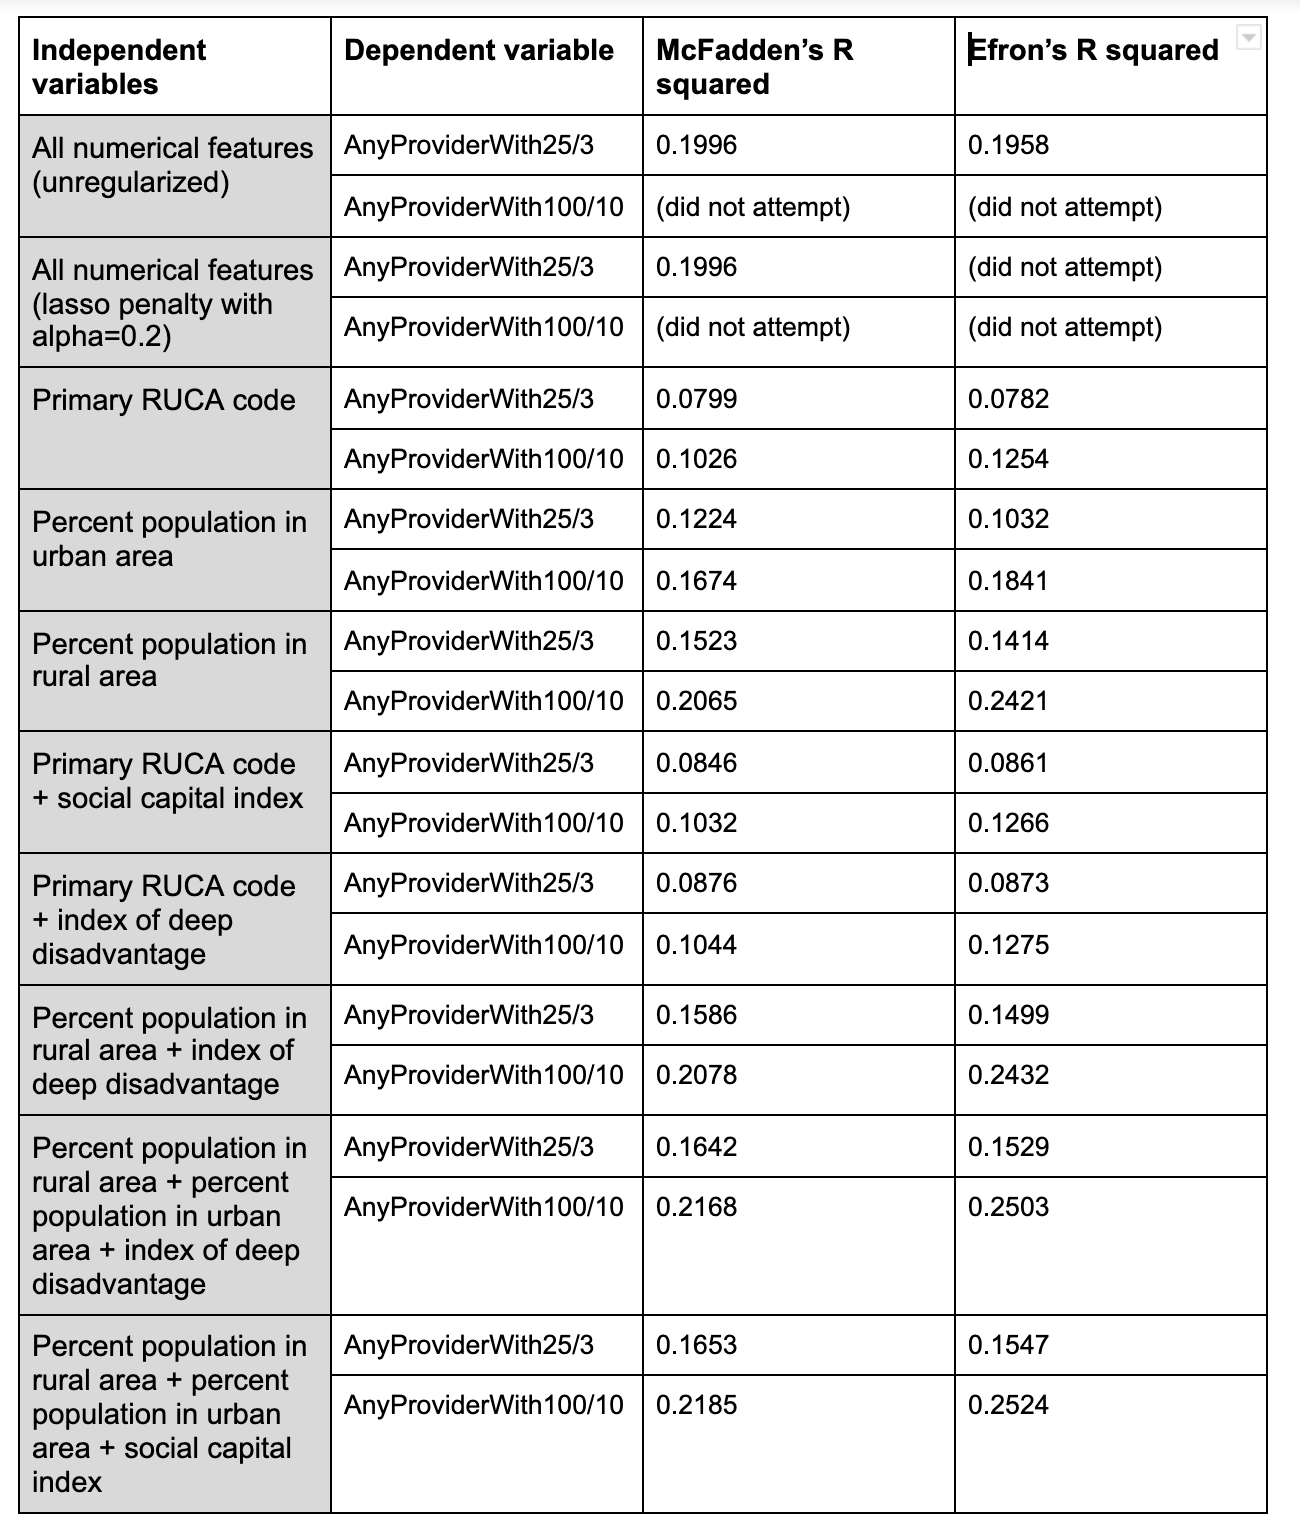

In [72]:
from IPython.display import Image
Image("/Users/yapinghe/Desktop/Screen Shot 2021-05-23 at 5.29.21 PM.png")
